In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import warnings

# Filter out warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, MinMaxScaler, OneHotEncoder, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV

# Train Dataframe

In [3]:
df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
null_table = pd.DataFrame()
null_table['Null prct'] = (df.isna().sum() / len(df)) * 100
null_table['null count'] = df.isna().sum() 
null_table['datatype'] = df.dtypes 
null_table = null_table.sort_values(by='Null prct', ascending = False)
null_table[null_table['null count'] > 0]

,Null prct,null count,datatype
CryoSleep,2.496261,217,object
ShoppingMall,2.392730,208,float64
VIP,2.335212,203,object
HomePlanet,2.312205,201,object
Name,2.300702,200,object
Cabin,2.289198,199,object
VRDeck,2.162660,188,float64
FoodCourt,2.105142,183,float64
Spa,2.105142,183,float64
Destination,2.093639,182,object


<Axes: >

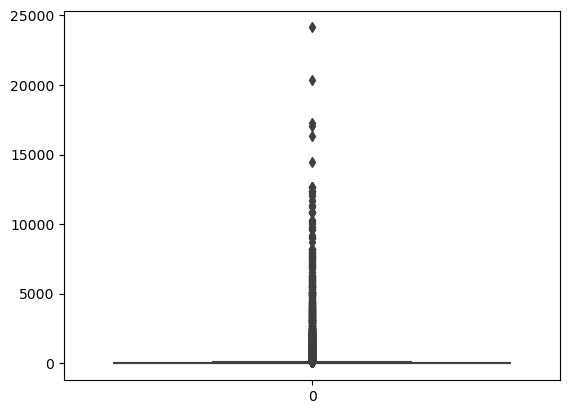

In [7]:
sns.boxplot(df.VRDeck)

In [8]:
df.select_dtypes(include=('object'))

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines
...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,True,Gravior Noxnuther
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,False,Kurta Mondalley
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,False,Fayey Connon
8691,9280_01,Europa,False,E/608/S,55 Cancri e,False,Celeon Hontichre


<Axes: ylabel='Density'>

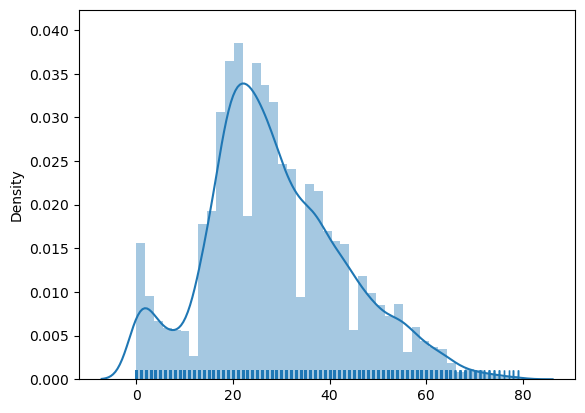

In [9]:
sns.distplot(x=df.Age, rug= True)

<Axes: xlabel='RoomService', ylabel='Density'>

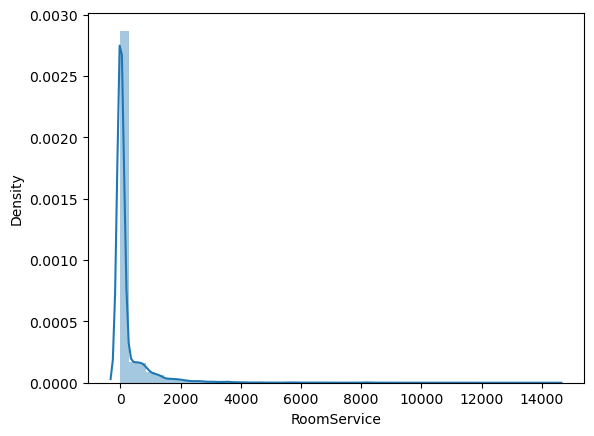

In [10]:
sns.distplot(df.RoomService)

<Axes: xlabel='VRDeck', ylabel='Density'>

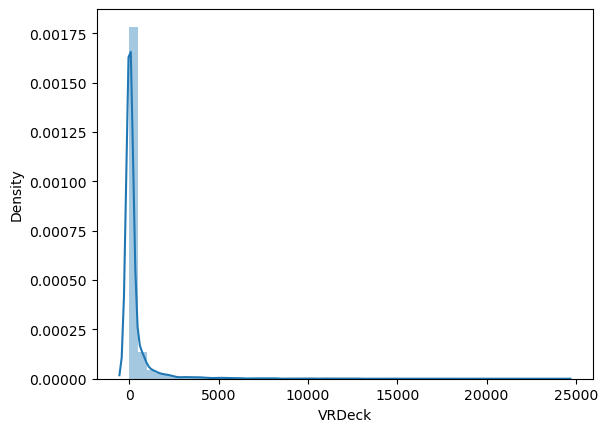

In [11]:
sns.distplot(df.VRDeck)

# Data Preprocessing and Pipeline

In [12]:
cv = df.copy()
cv['id'] = cv['PassengerId'].apply(lambda x: x.split('_')[0])
cv['subid'] = cv['PassengerId'].apply(lambda x: x.split('_')[1])
cv['total_partner'] = cv.groupby('id')['id'].transform('count') - 1
df = cv.drop(columns=['Name','id','subid','PassengerId','Cabin'])

In [13]:
objs = list(df.select_dtypes(include=['object']))
nums = list(df.select_dtypes(include=['float','int']))
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,total_partner
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,1
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,1
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,0
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,0
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,0
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,1


In [14]:
y = df['Transported']
X = df.drop(columns=['Transported'])

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [15]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, nums),
        ('cat', cat_transformer, objs)
    ])

# Define the complete pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_trans = pipe.fit_transform(X_train)
X_test_trans = pipe.fit_transform(X_test)


In [16]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'total_partner']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP'])]))])

# Model Building

* ###  Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,auc,roc_curve,classification_report,precision_recall_curve

linreg = LogisticRegression(penalty='none',solver='newton-cholesky')
linreg.fit(X_train_trans,y_train)
y_pred = linreg.predict(X_test_trans)

print(f'Classification Report:\n',classification_report(y_test,y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.80      0.74      0.77      1289
        True       0.76      0.82      0.79      1319

    accuracy                           0.78      2608
   macro avg       0.78      0.78      0.78      2608
weighted avg       0.78      0.78      0.78      2608



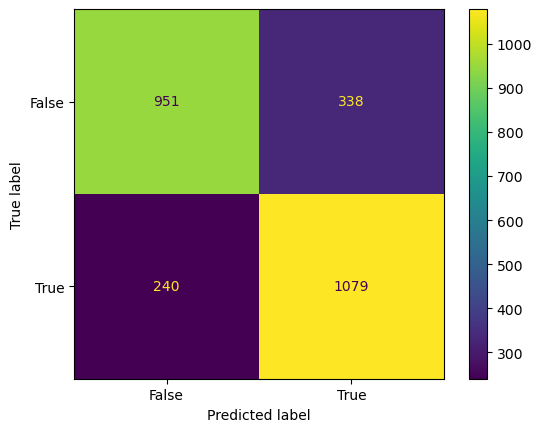

In [18]:
confuse_matrix = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confuse_matrix,
                              display_labels=linreg.classes_)
disp.plot()

plt.show()

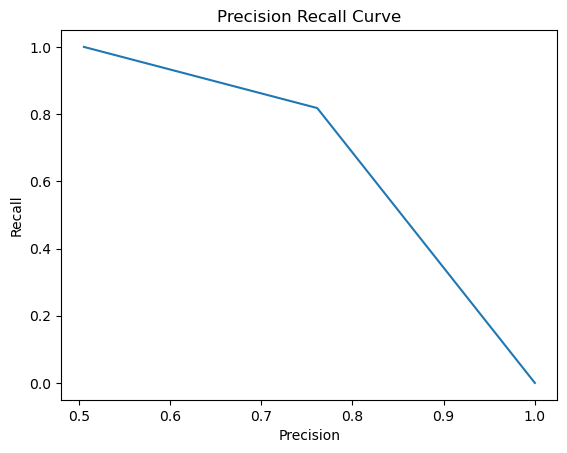

In [19]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
sns.lineplot(x=precision, y=recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve')
plt.show()

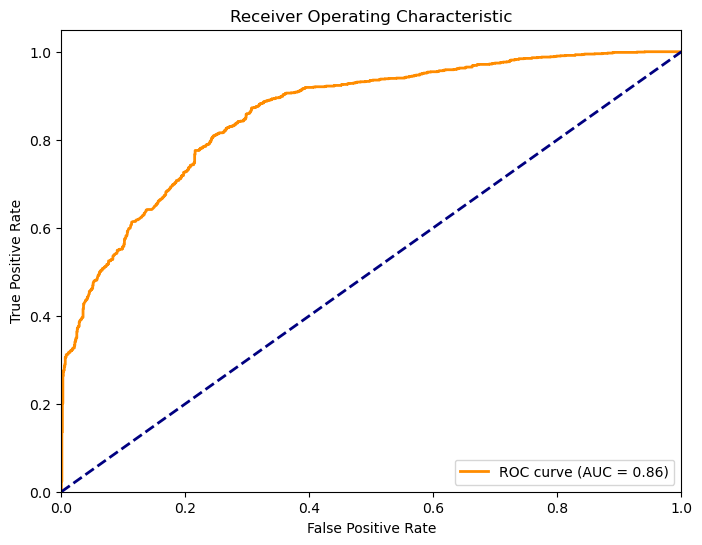

In [20]:
# Predict probabilities for the positive class
y_pred_proba = linreg.predict_proba(X_test_trans)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

* ### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1,n_estimators=1000)
rfc.fit(X_train_trans,y_train)
y_rfc_pred = rfc.predict(X_test_trans)
print(f'Random Forrest Classifier Report:\n',classification_report(y_test,y_rfc_pred))

Random Forrest Classifier Report:
               precision    recall  f1-score   support

       False       0.78      0.76      0.77      1289
        True       0.77      0.79      0.78      1319

    accuracy                           0.77      2608
   macro avg       0.77      0.77      0.77      2608
weighted avg       0.77      0.77      0.77      2608



* ### GradientBoosting Classifier

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=1500,max_depth=None,learning_rate=0.1)
gbc.fit(X_train_trans,y_train)
y_gcb_pred = gbc.predict(X_test_trans)

In [23]:
print(f'reportj:\n', classification_report(y_test,y_gcb_pred))

reportj:
               precision    recall  f1-score   support

       False       0.74      0.72      0.73      1289
        True       0.73      0.75      0.74      1319

    accuracy                           0.73      2608
   macro avg       0.73      0.73      0.73      2608
weighted avg       0.73      0.73      0.73      2608



* ### Support Vector Classifier

In [24]:
from sklearn.svm import SVC

svc = SVC(C=0.01, kernel='sigmoid',probability=True)
svc.fit(X_train_trans,y_train)

SVC(C=0.01, kernel='sigmoid', probability=True)

In [25]:
y_svc_pred = svc.predict(X_test_trans)

print('Classification Report of Support Vector Machine: \n\n',classification_report(y_test,y_svc_pred))

Classification Report of Support Vector Machine: 

               precision    recall  f1-score   support

       False       0.67      0.86      0.75      1289
        True       0.81      0.59      0.68      1319

    accuracy                           0.72      2608
   macro avg       0.74      0.72      0.72      2608
weighted avg       0.74      0.72      0.72      2608



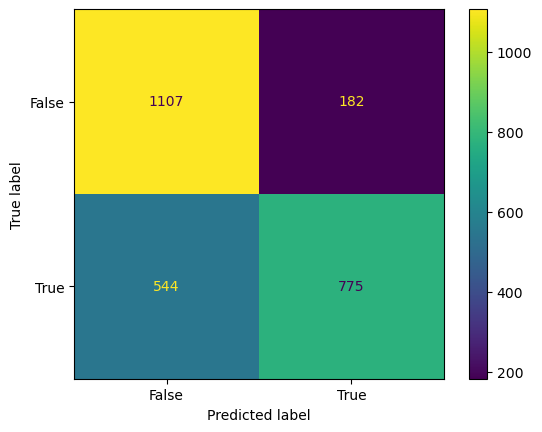

In [26]:
confuse_matrix = confusion_matrix(y_test,y_svc_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confuse_matrix,
                              display_labels=svc.classes_)
disp.plot()

plt.show()

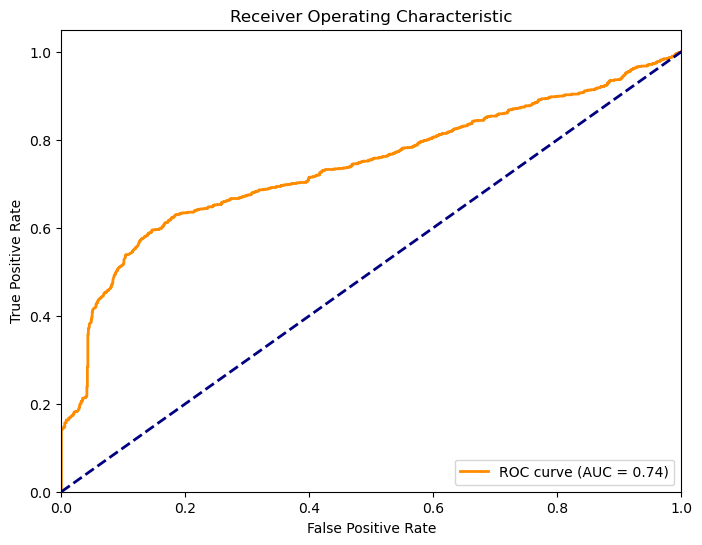

In [27]:
# Predict probabilities for the positive class
y_pred_proba_svc = svc.predict_proba(X_test_trans)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_svc)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Neural Network

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,InputLayer, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
model = Sequential(
    [
        InputLayer(input_shape=X_train_trans.shape[1]),
        Dense(312, activation='tanh'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(74,activation='relu'),
        Dense(54, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 312)               5616      
                                                                 
 batch_normalization (BatchN  (None, 312)              1248      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 312)               0         
                                                                 
 dense_1 (Dense)             (None, 74)                23162     
                                                                 
 dense_2 (Dense)             (None, 54)                4050      
                                                                 
 dense_3 (Dense)             (None, 1)                 55        
                                                        

In [30]:
model.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
cfs_nn = model.fit(X_train_trans,y_train, epochs=100,batch_size=12, validation_split=0.1, callbacks=[early_stopping])
loss, accuracy = model.evaluate(X_test_trans, y_test)

Epoch 1/100
457/457 [==============================] - 3s 3ms/step - loss: 0.5598 - accuracy: 0.7133 - val_loss: 0.4810 - val_accuracy: 0.7668
Epoch 2/100
457/457 [==============================] - 1s 2ms/step - loss: 0.5104 - accuracy: 0.7407 - val_loss: 0.4616 - val_accuracy: 0.7652
Epoch 3/100
457/457 [==============================] - 1s 2ms/step - loss: 0.5054 - accuracy: 0.7511 - val_loss: 0.4056 - val_accuracy: 0.8079
Epoch 4/100
457/457 [==============================] - 1s 2ms/step - loss: 0.4860 - accuracy: 0.7630 - val_loss: 0.4153 - val_accuracy: 0.8046
Epoch 5/100
457/457 [==============================] - 1s 2ms/step - loss: 0.4832 - accuracy: 0.7635 - val_loss: 0.4072 - val_accuracy: 0.8144
Epoch 6/100
457/457 [==============================] - 1s 2ms/step - loss: 0.4770 - accuracy: 0.7641 - val_loss: 0.4557 - val_accuracy: 0.7980
Epoch 7/100
457/457 [==============================] - 1s 2ms/step - loss: 0.4725 - accuracy: 0.7714 - val_loss: 0.4129 - val_accuracy: 0.8046

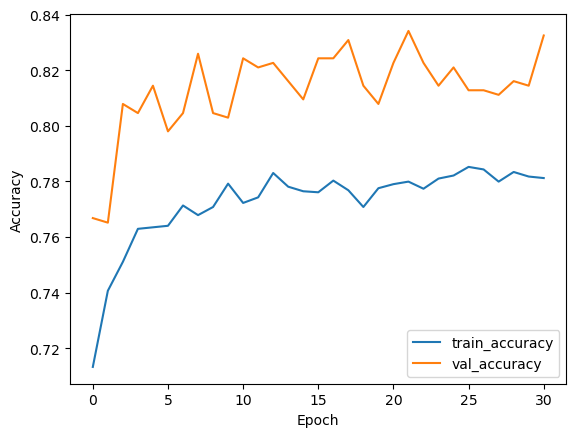

In [31]:

plt.plot(cfs_nn.history['accuracy'], label='train_accuracy')
plt.plot(cfs_nn.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

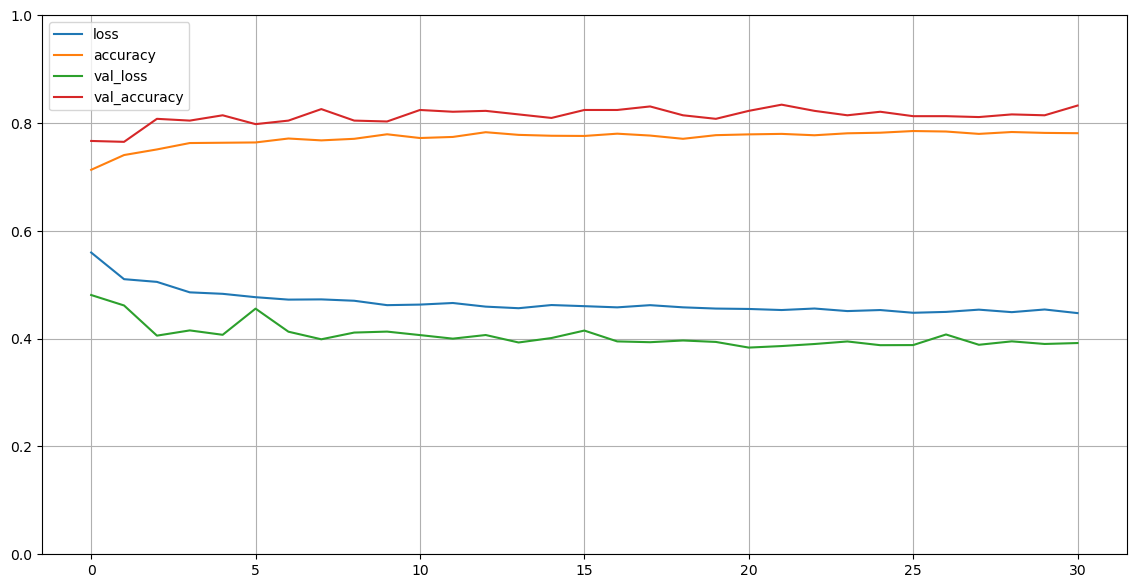

In [32]:
pd.DataFrame(cfs_nn.history).plot(figsize=(14,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()